# Lab 1: Segmentacion

Debe formar grupo de hasta 3 personas para los laboratorios.

__Estudiante 1:__ Leonardo Achá Boiano \
__Estudiante 2:__ Bruno Ramiro Rejas Montero \
__Estudiante 3:__ Matias Adorno Mazzocato

__Fecha de inicio:__ 2 de Marzo del 2023 \
__Fecha de entrega:__ 20 de Marzo del 2023 (11:59 pm)

## Importante

El objetivo de los laboratorios es mostrar la implementación práctica de los temas presentados durante la clase, así como preparar los para el proyecto final, que es un proyecto práctico que une los temas del curso.

Como tal, en los  laboratorios/proyecto final, a menos que se especifique lo contrario, debe utilizar funciones de procesamiento de imágenes/libraries como ser `opencv` y `sklearn`. 

Sin embargo, por cada funcion utilizada se debe dar una explicación suficiente en el informe de laboratorio. Note que no se necesita implementar un detector de bordes propio, etc.

Por otro lado, existen algunas funciones, algoritmos, que no estan presentes en `opencv` como por ejemplo `region growing`. Como ya se menciono, no se quiere que lo implementen desde cero si no que busquen en otras librerias para utilizar dicho algoritmo. Una libreria que se usa en conjunto con `opencv` es `sklearn` (Note que puede realizar el laboratorio utilizando solamente una libreria pero si lo desea puede usar ambas). 

Para instalar la libreria scikit-image corra el siguiente comando ([scikit-image](https://scikit-image.org/docs/stable/install.html#install-via-pip)):

```bash
python -m pip install -U scikit-image
```


A continuacion, se muestra algunas funciones de `scikit-image` que le podria ser de utilidad:

- skimage.exposure.is_low_contrast
- exposure.rescale_intensity
- skimage.measure.label
- skimage.color.label2rgb
- skimage.measure.regionprops
- scipy.ndimage.gaussian_laplace (OpenCV tambien permite realizar el LOG)

Entre otros metodos. Revise la documentacion.

Note que debe guardar todos los experimentos posibles para documentar la elaboracion del laboratorio.

**Antes de entregar la notebook <font color='red'> rerun </font>la notebook from scratch !**
`Kernel` > `Restart & Run All`

## Extraer la Data

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.getcwd(), 'images')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Parte 1: Segmentacion

__Objetivo:__ calcular el tamaño del cerebro (sin el cráneo) en píxeles en una imagen 2D de una cabeza humana tomada por Imágenes por resonancia magnética (MRI) mediante:

* Region growing (5 pts)
* Detección de contornos (5 pts)
    - LOG
    - Sobel
    - Canny 

Cada sección debe mostrar la segmentación resultante, así como el tamaño en píxeles de la región detectada. Tambien, debe realizar comentarios, limitaciones y/o ventajas de cada método.

Analice sus resultados, pruebe todas las formas posibles (mientras mas mejor). Nuevamente, no se rompera nada si probamos varios metodos. Recuerde siempre hacer una copia original de la imagen.


__Importante__
Guardar la imagen en con la cantidad de pixeles en cada iteracion y comparar los resultados bajo distintos metodos.

## Visualizacion de la imagen

In [2]:
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


%matplotlib inline

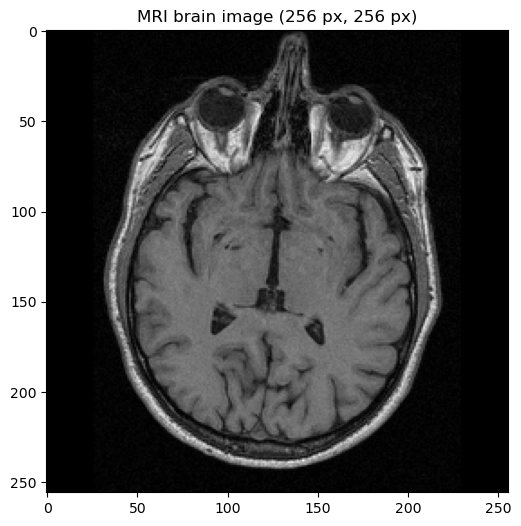

(256, 256)


In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
brain_img=brain_im.copy()

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title(f'MRI brain image ({im_h} px, {im_w} px)')
ax.axis('on')
plt.show()
print(brain_img.shape)

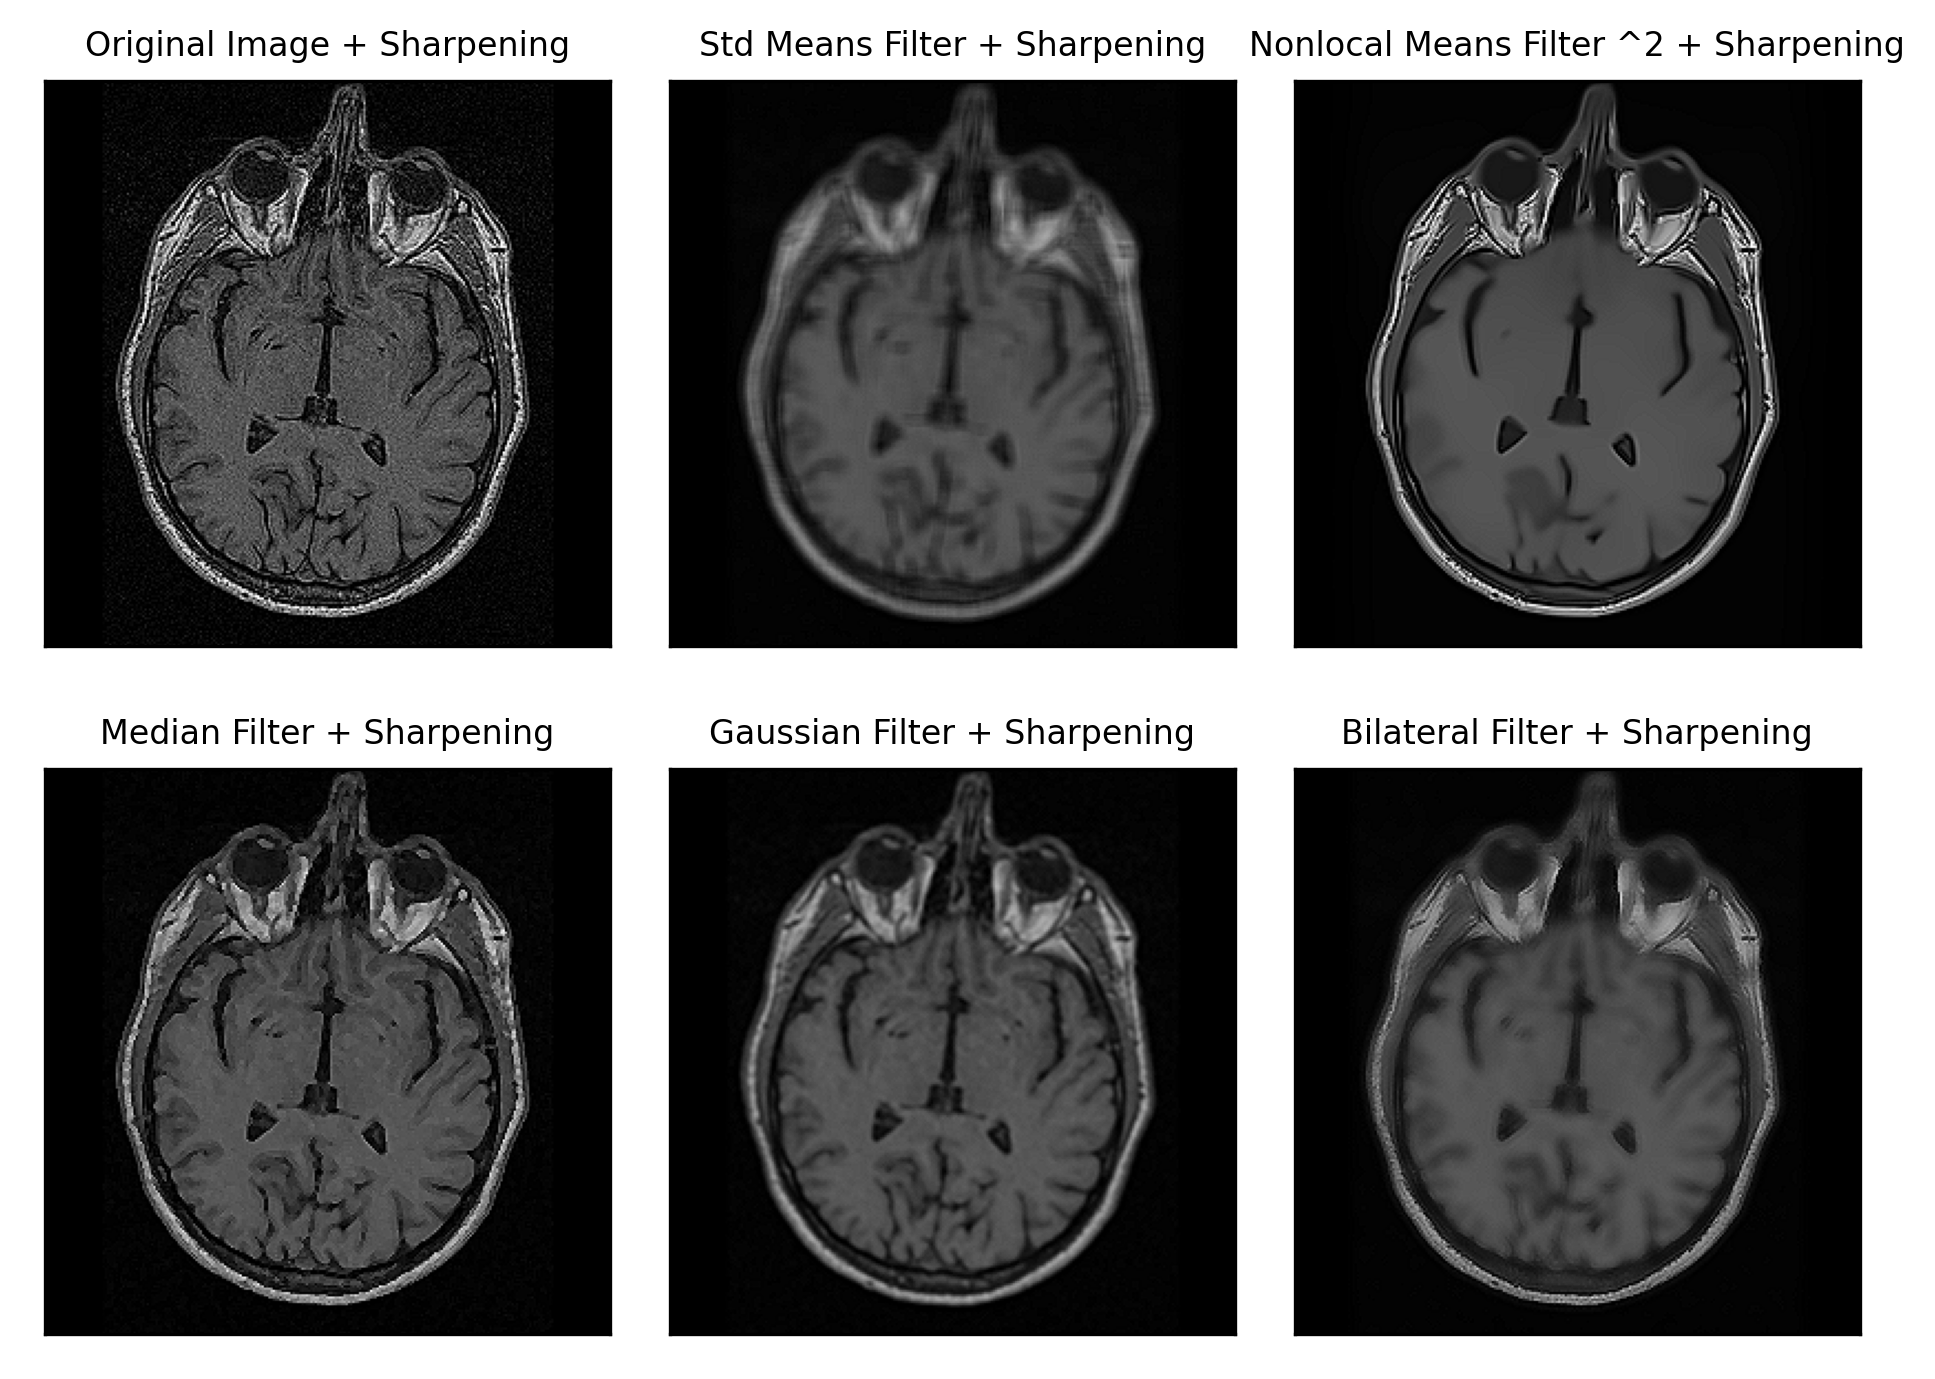

In [4]:
#image filtering
filters_str=['Original Image','Std Means Filter',
             'Nonlocal Means Filter ^2','Median Filter',
             'Gaussian Filter', 'Bilateral Filter']
images=[brain_img]
filter_size=6
low_pass_kernel=np.ones((filter_size,filter_size),np.float32)/filter_size**2
images.append(cv2.filter2D(src=brain_img, 
                           ddepth=-1, kernel=low_pass_kernel)) #standart mean filter
images.append(cv2.fastNlMeansDenoising(brain_img, 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10)) #Nonlocal means denoising algorithm
images[2]=cv2.fastNlMeansDenoising(images[2], 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10) #Nonlocal means denoising algorithm
images.append(cv2.medianBlur(brain_img, 3))
images.append(cv2.GaussianBlur(brain_img,(5,5),0)) #gaussian filter
images.append(cv2.bilateralFilter(brain_img, 9,60,60)) #bilateral filter

sharpen_kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
for i in range(len(images)):
    images[i]=sharpenOutput=cv2.filter2D(src=images[i], ddepth=-1, kernel=sharpen_kernel)

fig=plt.figure(dpi=300)
for i in range(len(images)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(f"{filters_str[i]} + Sharpening", fontsize=8)
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
plt.show()


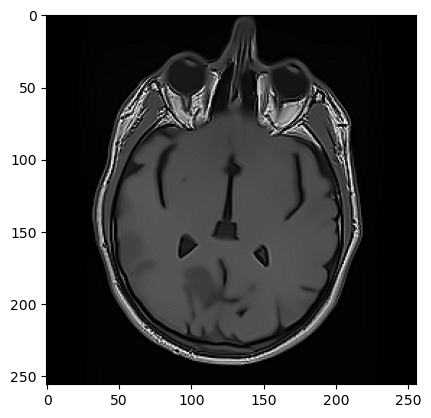

In [5]:
plt.imshow(images[2],'gray',vmin=0,vmax=255)

## 1.1 Region growing (5 pts)

Region growing is an iterative method used to extract similar parts of an image. One or several points are chosen as a start. The region then grows until it is finally blocked by the stop criteria. This criteria is generally an inside/outside region comparison (energy, size, . . .).  

In [6]:
# YOU CODE HERE AND DISCUSSION
def region_growing(img, seed, tolerance=0.1, color=255):
    """
    Segment an image using region growing.
    
    Args:
        img (np.ndarray): The input image.
        seed (tuple): The pixel coordinates (x, y) of the seed point.
        tolerance (float): Allowed difference between seed value and neighborhood
        color (int) = mask color
    
    Returns:
        np.ndarray: The segmented image mask.
    """
    # Initialize segmented image with zeros
    segmented = np.zeros_like(img)
    
    # Initialize queue with seed point
    queue = [seed]
    
    # Get seed point color
    seed_color = img[seed]
    
    # Loop until the queue is empty
    while queue:
        # Get next pixel from queue
        pixel = queue.pop(0)
        
        # Check if pixel is within image bounds
        if (0 <= pixel[0] < img.shape[0]) and (0 <= pixel[1] < img.shape[1]):
            # Check if pixel is unsegmented and similar to seed color
            if segmented[pixel[0], pixel[1]] == 0 and np.allclose(img[pixel], seed_color, rtol=tolerance, atol=tolerance):
                # Segment pixel
                segmented[pixel[0], pixel[1]] = color
                
                # Add neighboring pixels to queue
                queue.append((pixel[0] - 1, pixel[1]))
                queue.append((pixel[0] + 1, pixel[1]))
                queue.append((pixel[0], pixel[1] - 1))
                queue.append((pixel[0], pixel[1] + 1))
    
    return segmented


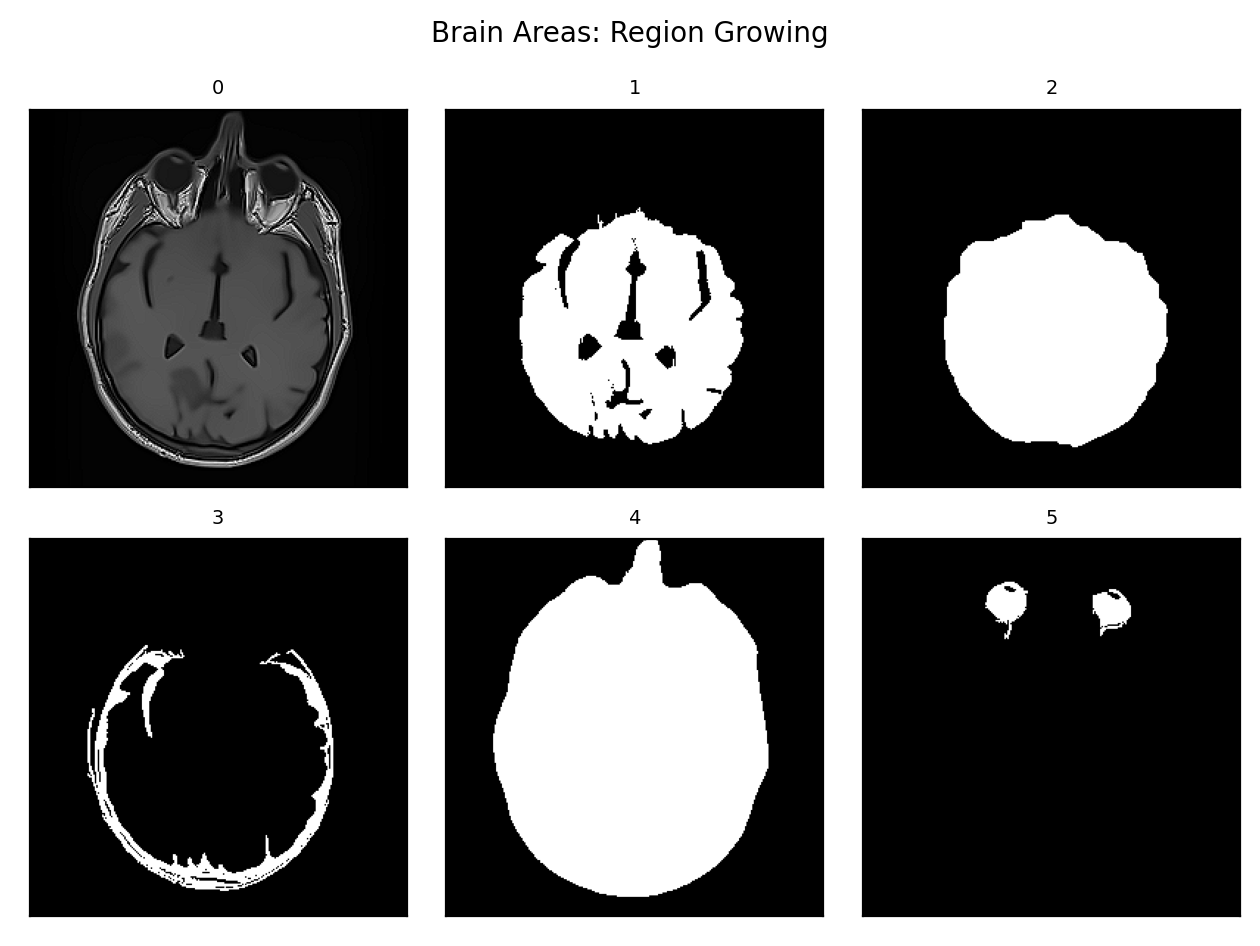

In [7]:
brain_areas=[images[2]]

# Apply region growing segmentation
brain_areas.append(region_growing(images[2], (100, 100), 0.23))
brain_areas.append(cv2.morphologyEx(brain_areas[1], cv2.MORPH_CLOSE, 
                    cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4)),
                    iterations=5))
brain_areas.append(region_growing(images[2], (175, 50), 0.99))
brain_areas.append(cv2.bitwise_not(region_growing(images[2], (50, 250), 10)))
brain_areas.append(region_growing(images[2], (50, 100), 1)+region_growing(images[2], (50, 175), 1))

# Display results
fig=plt.figure(dpi=200)
for i in range(len(brain_areas)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(brain_areas[i],'gray',vmin=0,vmax=255)
    plt.title(i, fontsize=7)
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
fig.suptitle('Brain Areas: Region Growing', fontsize=10)
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig("results/Ex1.1-Brain-Areas-Region-Growing.png",bbox_inches='tight')

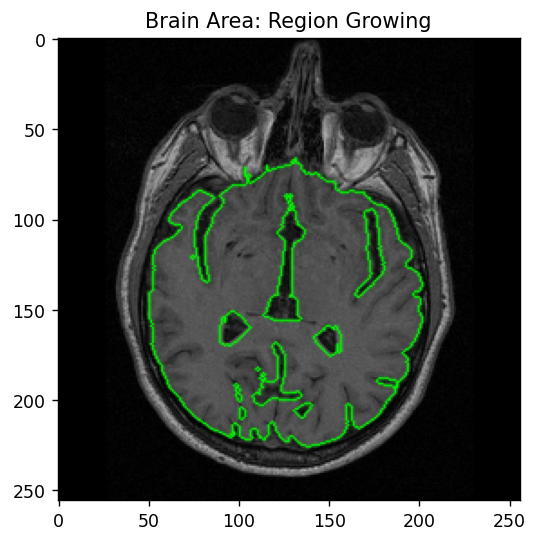

In [8]:
# detect the contours on the binary image
contour, hierarchy = cv2.findContours(image=brain_areas[1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the original image
image_copy = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
cv2.drawContours(image=image_copy, contours=contour, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
fig=plt.figure(dpi=125)
plt.imshow(image_copy,'gray',vmin=0,vmax=255)
plt.title('Brain Area: Region Growing')
fig.savefig("results/Ex1.1-Brain-Area-Region-Growing.png",bbox_inches='tight')

In [9]:
contours=[]
contour, hierarchy = cv2.findContours(image=brain_areas[1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
contours.append(contour)
cv2.contourArea(contour[0])

17707.5

In [10]:
contour, hierarchy = cv2.findContours(image=brain_areas[2], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
contours.append(contour)
cv2.contourArea(contour[0])

18213.5

In [11]:
print(f"El area del cerebro está en el rango de {np.count_nonzero(brain_areas[1] == 255)} a {np.count_nonzero(brain_areas[2] == 255)} pixeles.")

El area del cerebro está en el rango de 16652 a 18442 pixeles.


## 1.2 Contour detection (5 pts)

In [12]:
#apply mask of brain_areas[4] to images[2] in order to eliminate any background noise befour contour detection
images[2][brain_areas[4]<255]=0
#Equalizate histogram -> Add contrast to image
#images[2]=cv2.equalizeHist(images[2])

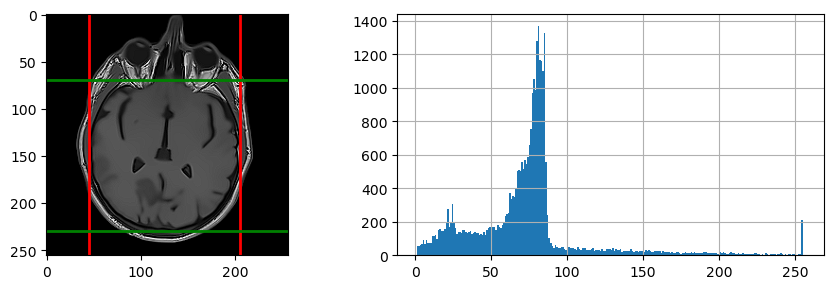

In [13]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(images[2],'gray',vmin=0,vmax=255)
plt.axvline(45, color='r', linewidth=2)
plt.axvline(205, color='r', linewidth=2)
plt.axhline(70, color='g', linewidth=2)
plt.axhline(230, color='g', linewidth=2)
plt.subplot(1,2,2)
plt.hist(images[2].ravel(),256,[1,256])
plt.tight_layout()
plt.grid()
plt.show()

In [14]:
# LOG


Acoording to opencv's [documentation](https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html):  
**Sobel Operator**  
1. The Sobel Operator is a discrete differentiation operator. It computes an approximation of the gradient of an image intensity function.  
2. The Sobel Operator combines Gaussian smoothing and differentiation.  
**Formulation**   
Assuming that the image to be operated is I:  
1. We calculate two derivatives:  
a. Horizontal changes: This is computed by convolving I with a kernel Gx with odd size. For example for a kernel size of 3, Gx would be computed as:    
$$ G_x=\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1
\end{bmatrix}*I$$  
b. Vertical changes: This is computed by convolving I with a kernel Gy with odd size. For example for a kernel size of 3, Gy would be computed as:   
$$ G_x=\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
+1 & +2 & +1
\end{bmatrix}*I$$  
2. At each point of the image we calculate an approximation of the gradient in that point by combining both results above:   
$$G=\sqrt{G_x^2+G_y^2}$$
Although sometimes the following simpler equation is used:   
$$G=|G_x|+|G_y|$$



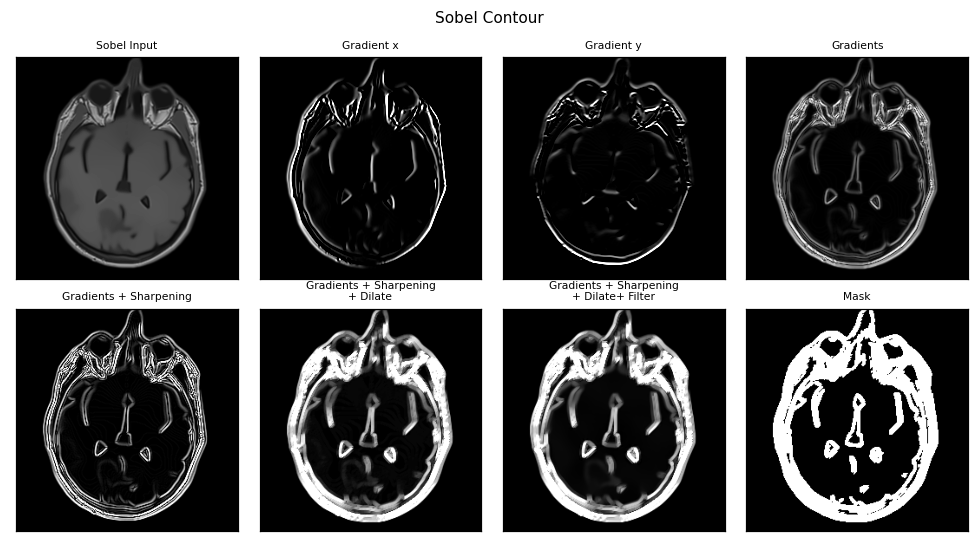

In [15]:
#SOBEL
scale = 1
delta = 0
ddepth = cv2.CV_16S

#image preprocessing for sobel edge detection
sobel_input=cv2.GaussianBlur(images[2],(3,3),0).copy() #Gaussian filter
#sobel_input=cv2.filter2D(src=images[2], ddepth=-1, kernel=np.array([[1,2,1],[2,4,2],[1,2,1]])*1/16).copy() #Averaging filter
sobel_input=cv2.fastNlMeansDenoising(sobel_input, templateWindowSize=7,searchWindowSize=21, h=10).copy()

grad_x = cv2.Sobel(sobel_input, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# Gradient-Y
grad_y = cv2.Sobel(sobel_input, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
#General Gradient
grad = cv2.addWeighted(cv2.convertScaleAbs(grad_x), 0.5, cv2.convertScaleAbs(grad_y), 0.5, 0)

gradients=[sobel_input, grad_x, grad_y, grad]
gradients_str=['Sobel Input', 'Gradient x', 'Gradient y', 'Gradients'] #Subplots' titles

#Apply sharpening
gradients.append(cv2.filter2D(src=gradients[-1], ddepth=-1, kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])))
gradients_str.append(f'{gradients_str[-1]} + Sharpening')

#Apply morphological operation
#gradients.append(cv2.erode(gradients[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1))
#gradients.append(cv2.erode(gradients[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations=2))
#gradients_str.append(f'{gradients_str[-1]}\n+ Erode')

gradients.append(cv2.dilate(gradients[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations=2))
gradients_str.append(f'{gradients_str[-1]}\n+ Dilate')

#Apply Denoising Filter
gradients.append(cv2.fastNlMeansDenoising(gradients[-1], templateWindowSize=7,searchWindowSize=21, h=10))
gradients_str.append(f'{gradients_str[-1]}+ Filter')

#Get Mask
gradients.append(cv2.bitwise_not(cv2.inRange(gradients[-1], 0, 50)))
gradients_str.append('Mask')

# Display results
#fig=plt.figure(dpi=150)
fig=plt.figure(figsize=(9,5), dpi=110)
for i in range(len(gradients)):
    fig.add_subplot(2,4,i+1)
    plt.imshow(gradients[i],'gray',vmin=0,vmax=255)
    plt.title(gradients_str[i], fontsize=7)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Sobel Contour', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
fig.savefig("results/Ex1.2-Brain-Area-Sobel-Process.png",bbox_inches='tight')

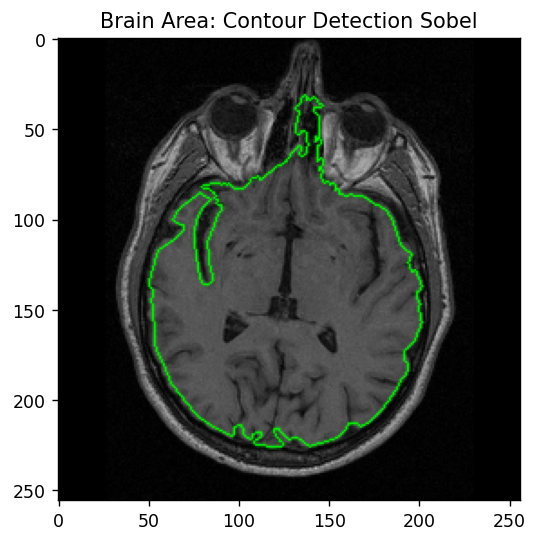

In [16]:
# detect the contours on the binary image
contour, hierarchy = cv2.findContours(image=gradients[-1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image
image_copy = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
fig=plt.figure(dpi=125)
cv2.drawContours(image=image_copy, contours=contour[86:87], contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
plt.imshow(image_copy,'gray',vmin=0,vmax=255)
plt.title('Brain Area: Contour Detection Sobel')
fig.savefig("results/Ex1.2-Brain-Area-Sobel.png",bbox_inches='tight')

In [17]:
print(f'La tecnica de deteccion de contornos mediante el operador de Sobel indica que el area del cerebro es de {int(cv2.contourArea(contour[86]))} pixeles')

La tecnica de deteccion de contornos mediante el operador de Sobel indica que el area del cerebro es de 17883 pixeles


In [18]:
#CANNY

---
## Parte 2: Segmentacion Forma/Color 

A continuación encontrará tres fotografías tomadas bajo tres iluminaciones diferentes, que contienen algunas formas con diferentes colores. Se pide que se cree una funcion para:

1. Contar el número de formas de cada color (solo color no distinción entre formas) (5pts).
2. Calcular el área total (en píxeles) de cada color (5 pts).

Note que esta funcion debe detectar realizar los pasos anteriores bajo cualquier ilumniacion. Por esto, tenga en cuenta que un desafío específico es ser resistente a los cambios de iluminación. Por lo tanto, en algun tipo de intensidad probablemente se debería realizar la normalizacion.

__Sugerencia__: el espacio de color RGB podría no ser óptimo. Considere usar el espacio de color HSV o LAB.

## 2.1 Visualizacion

In [19]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03',
            'arena-shapes-01-H', 'arena-shapes-01-S', 'arena-shapes-01-V',
            'arena-shapes-02-H', 'arena-shapes-02-S', 'arena-shapes-02-V',
            'arena-shapes-03-H', 'arena-shapes-03-S', 'arena-shapes-03-V']
#filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
filenames = ['images/lab-01-data/arena-shapes-01.png', 'images/lab-01-data/arena-shapes-02.png', 'images/lab-01-data/arena-shapes-03.png']

images = []
images_hsv = [cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_COLOR), cv2.COLOR_RGB2BGR) for filename in filenames]
for filename in filenames:
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img)
    images_hsv.append(h)
    images_hsv.append(s)
    images_hsv.append(v)
    
    if img is not None:
        images.append(img)
    
print(f'Number of images: {len(images_hsv)}')
print(f'Image size: {images[0].shape[:2]}')
#print(f'Number of color channels: {images_hsv[0].shape[-1]}')

Number of images: 12
Image size: (480, 640)


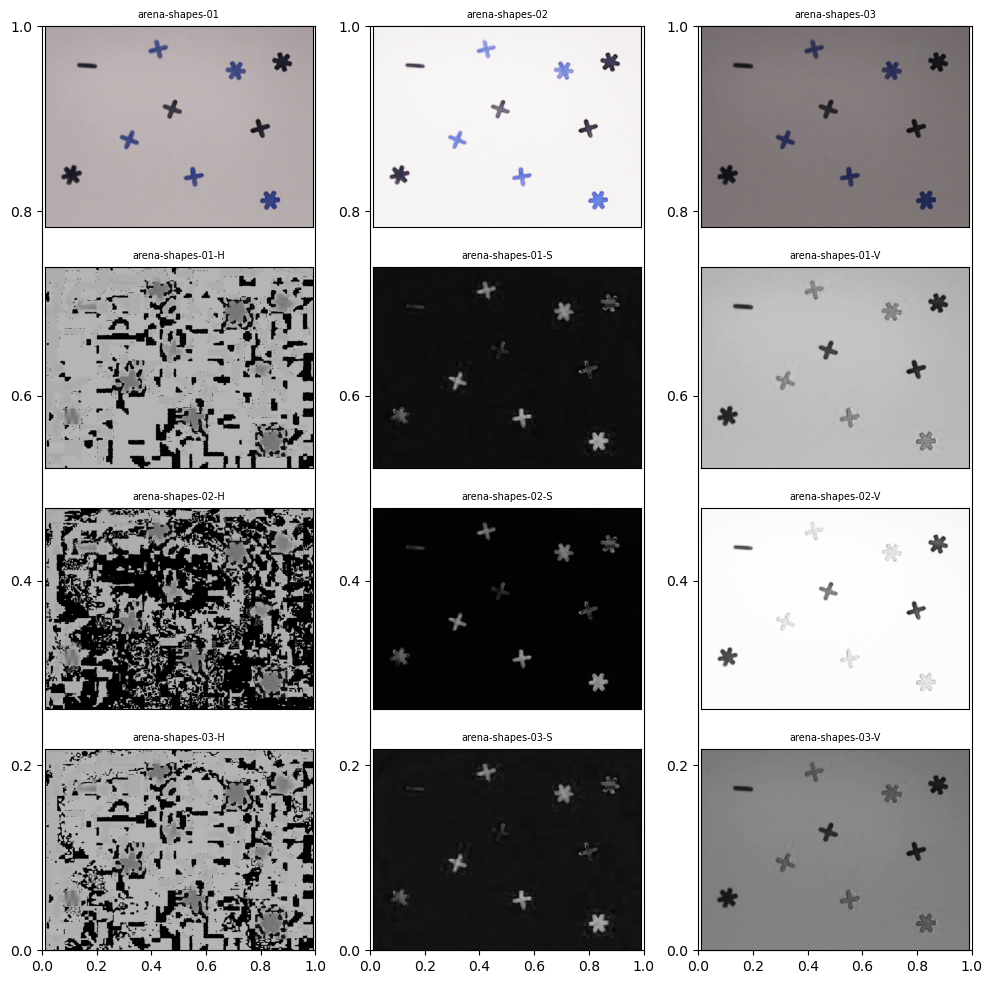

In [20]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for i in range(len(images_hsv)):
    fig.add_subplot(4,3,i+1)
    plt.imshow(images_hsv[i],'gray',vmin=0,vmax=250)
    plt.title(f"{im_names[i]}", fontsize=7)
    plt.xticks([]),plt.yticks([])
plt.show()

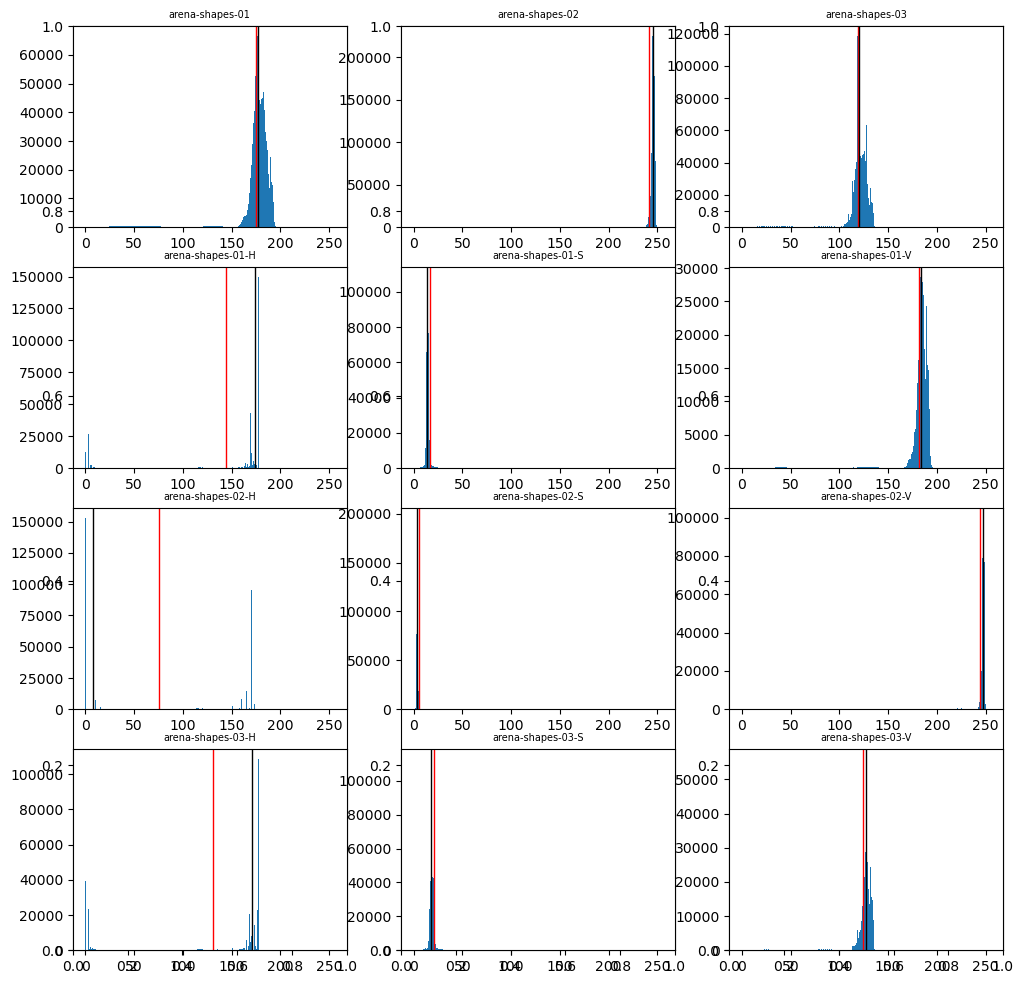

181.18620442708334
243.79261067708333
124.59666341145834


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for i in range(len(images_hsv)):
    fig.add_subplot(4,3,i+1)
    plt.title(f"{im_names[i]}", fontsize=7)
    plt.hist(images_hsv[i].ravel(), 255, [0,255])
    plt.axvline(np.mean(images_hsv[i]), color='r', linewidth=1)
    plt.axvline(np.median(images_hsv[i]), color='k', linewidth=1)
    #plt.imshow(images_hsv[i],'gray',vmin=0,vmax=255)
    #plt.title(f"{im_names[i]}", fontsize=7)
    #plt.xticks([]),plt.yticks([])
plt.show()

print(np.mean(images_hsv[5]))
print(np.mean(images_hsv[8]))
print(np.mean(images_hsv[11]))

In [22]:
im_names2 = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
Filenames = ['images/lab-01-data/arena-shapes-01.png', 'images/lab-01-data/arena-shapes-02.png', 'images/lab-01-data/arena-shapes-03.png']
imagess = [] 
#lower_range = np.array([220, 8, 5])  # Rango mínimo de color en formato HSV
#upper_range = np.array([280, 65, 90])  # Rango máximo de color en formato HSV
lower_range = np.array([0, 0, 0])  # Rango mínimo de color en formato HSV
upper_range = np.array([179, 255, 100])  # Rango máximo de color en formato HSV
#lower_hue = np.array([160,0,0]) 
#upper_hue = np.array([180,255,255])

for Filename in Filenames:
    image = cv2.imread(Filename, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(image, lower_range, upper_range)
    #mask = cv2.inRange(image, lower_hue, upper_hue)
    masked_image = np.copy(image)
    #masked_image[mask==0] = [250,250,250]

    #imagess.append(masked_image)
    imagess.append(mask)
    
print(f'Number of image: {len(imagess)}')
#print(f'Image size: {imagess[0].shape[:2]}')



Number of image: 3


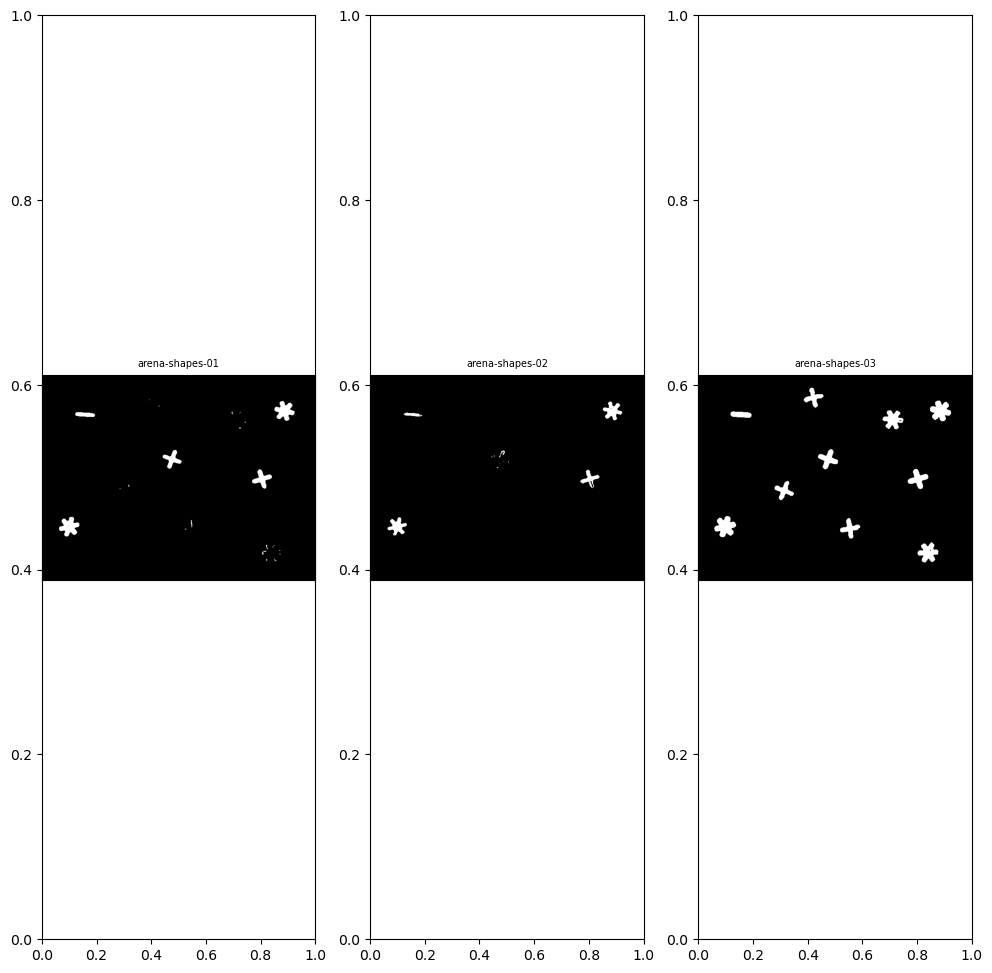

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for i in range(len(imagess)):
    fig.add_subplot(1,3,i+1)
    plt.imshow(imagess[i],'gray',vmin=0,vmax=255)
    plt.title(f"{im_names2[i]}", fontsize=7)
    plt.xticks([]),plt.yticks([])
plt.show()

## 2.2 Numero de formas (shapes) de cada color (5 pts)

In [24]:
# YOU CODE HERE AND DISCUSSION


## 2.3 Area total (en pixeles) de cada color (5 pts)

In [25]:
# YOU CODE HERE AND DISCUSSION